In [1]:
import numpy as np
import pandas as pd

quora_questions = pd.read_csv("../input/train.csv")

print("Quora question set rows:", quora_questions.shape[0])
print("Quora question set columns:", quora_questions.shape[1])

quora_questions.head()

Quora question set rows: 1306122
Quora question set columns: 3


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [2]:
class_balance = quora_questions["target"].value_counts()

print("Total non-toxic questions:", class_balance[0])
print("Non-toxic proportion:", round(class_balance[0] / quora_questions.shape[0], 4) * 100)
print("Total toxic questions:", class_balance[1])
print("Toxic proportion:", round(class_balance[1] / quora_questions.shape[0], 4) * 100)

Total non-toxic questions: 1225312
Non-toxic proportion: 93.81
Total toxic questions: 80810
Toxic proportion: 6.1899999999999995


In [3]:
from sklearn.model_selection import train_test_split

quora_sentences = quora_questions["question_text"].values

target = quora_questions["target"].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    quora_sentences, target, test_size=0.25, random_state=1017
)

print("Quora questions training set rows:", sentences_train.shape[0])
print("Quora questions test set rows:", sentences_test.shape[0])

Quora questions training set rows: 979591
Quora questions test set rows: 326531


In [4]:
from keras.models import Model
from keras.preprocessing import text, sequence

tokenizer = text.Tokenizer(num_words=50000)
tokenizer.fit_on_texts(sentences_train)
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

Using TensorFlow backend.


In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
from keras.layers import Dropout

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=50, 
                           input_length=100))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = "rmsprop", metrics=['binary_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           9482050   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,573,827
Trainable params: 9,573,827
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_history = model.fit(X_train, y_train, 
                          batch_size=1024, 
                          epochs=5,
                          validation_split=.25,
                          verbose=True)

Train on 734693 samples, validate on 244898 samples
Epoch 1/5
734693/734693 [==============================] - 131s 178us/step - loss: 0.1444 - binary_accuracy: 0.9481 - val_loss: 0.1235 - val_binary_accuracy: 0.9509
Epoch 2/5
734693/734693 [==============================] - 129s 176us/step - loss: 0.1159 - binary_accuracy: 0.9549 - val_loss: 0.1157 - val_binary_accuracy: 0.9546
Epoch 3/5
734693/734693 [==============================] - 128s 174us/step - loss: 0.1111 - binary_accuracy: 0.9564 - val_loss: 0.1149 - val_binary_accuracy: 0.9549
Epoch 4/5
734693/734693 [==============================] - 127s 173us/step - loss: 0.1087 - binary_accuracy: 0.9576 - val_loss: 0.1159 - val_binary_accuracy: 0.9546
Epoch 5/5
734693/734693 [==============================] - 123s 167us/step - loss: 0.1072 - binary_accuracy: 0.9583 - val_loss: 0.1160 - val_binary_accuracy: 0.9547


In [7]:
lstm_probs = model.predict_proba(X_test, verbose=1)

326531/326531 [==============================] - 565s 2ms/step


In [8]:
y_test = pd.DataFrame(y_test)

prob_df = pd.DataFrame(lstm_probs)

prob_df = pd.concat([y_test.reset_index(drop=True), prob_df], axis=1)

prob_df.columns = ["target",  "probs"]

prob_df["pred"] = np.where(prob_df["probs"] >= .5, 1, 0)

prob_df.head()

,target,probs,pred
0,0,0.000632,0
1,0,0.003769,0
2,0,0.000170,0
3,0,0.335430,0
4,0,0.009570,0


In [9]:
from sklearn.metrics import classification_report

print(classification_report(prob_df["target"],prob_df["pred"]))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    306198
           1       0.68      0.52      0.59     20333

   micro avg       0.95      0.95      0.95    326531
   macro avg       0.83      0.75      0.78    326531
weighted avg       0.95      0.95      0.95    326531



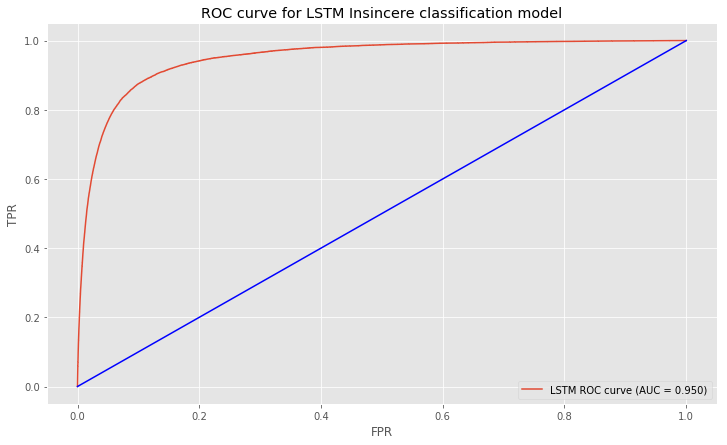

In [10]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fpr, tpr, _ = metrics.roc_curve(prob_df["target"], prob_df["probs"])

plt.figure(figsize = (12, 7))

plt.plot(fpr, tpr, label = "LSTM ROC curve (AUC = %0.3f)" % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color = "blue")
plt.legend(loc = 4)
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ROC curve for LSTM Insincere classification model")
plt.show()

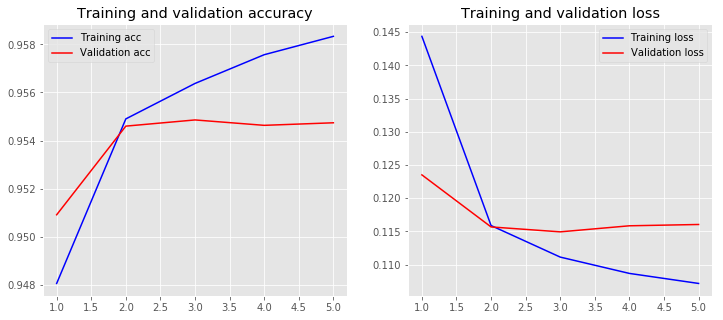

In [11]:
def plot_history(history):
    acc = history.history["binary_accuracy"]
    val_acc = history.history["val_binary_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    
plot_history(history=model_history)

In [12]:
from keras.layers import BatchNormalization
from keras.layers import Bidirectional

model_two = Sequential()
model_two.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=50, 
                           input_length=100))
model_two.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout = 0.5)))
model_two.add(BatchNormalization())
model_two.add(Dropout(rate = .5))

model_two.add(Bidirectional(LSTM(units=128, recurrent_dropout = .5)))
model_two.add(BatchNormalization())
model_two.add(Dropout(rate = .5))
model_two.add(Dense(activation="sigmoid", units=1))

model_two.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["binary_accuracy"])

model_two.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           9482050   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          58880     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128)          512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

In [13]:
model_two_history = model_two.fit(X_train, y_train, 
                                  batch_size=1024, 
                                  epochs=5,
                                  validation_split=.25,
                                  verbose=True)

Train on 734693 samples, validate on 244898 samples
Epoch 1/5
734693/734693 [==============================] - 537s 730us/step - loss: 0.1925 - binary_accuracy: 0.9205 - val_loss: 0.1377 - val_binary_accuracy: 0.9500
Epoch 2/5
734693/734693 [==============================] - 530s 721us/step - loss: 0.1164 - binary_accuracy: 0.9543 - val_loss: 0.1133 - val_binary_accuracy: 0.9557
Epoch 3/5
734693/734693 [==============================] - 530s 721us/step - loss: 0.1083 - binary_accuracy: 0.9580 - val_loss: 0.1146 - val_binary_accuracy: 0.9555
Epoch 4/5
734693/734693 [==============================] - 536s 730us/step - loss: 0.1030 - binary_accuracy: 0.9605 - val_loss: 0.1215 - val_binary_accuracy: 0.9550
Epoch 5/5
734693/734693 [==============================] - 532s 724us/step - loss: 0.0990 - binary_accuracy: 0.9627 - val_loss: 0.1167 - val_binary_accuracy: 0.9546


In [14]:
lstm_two_probs = model_two.predict_proba(X_test, verbose=1)

326531/326531 [==============================] - 2331s 7ms/step


In [15]:
y_test = pd.DataFrame(y_test)

prob_df = pd.DataFrame(lstm_two_probs)

prob_df = pd.concat([y_test.reset_index(drop=True), prob_df], axis=1)

prob_df.columns = ["target",  "probs"]

prob_df["pred"] = np.where(prob_df["probs"] >= .5, 1, 0)

prob_df.head()

,target,probs,pred
0,0,0.001569,0
1,0,0.001434,0
2,0,0.000432,0
3,0,0.448740,0
4,0,0.009832,0


In [16]:
print(classification_report(prob_df["target"],prob_df["pred"]))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    306198
           1       0.65      0.60      0.62     20333

   micro avg       0.95      0.95      0.95    326531
   macro avg       0.81      0.79      0.80    326531
weighted avg       0.95      0.95      0.95    326531



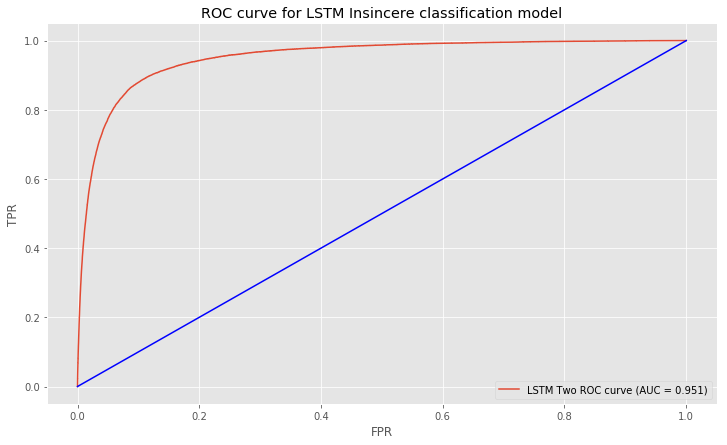

In [17]:
plt.style.use("ggplot")

fpr, tpr, _ = metrics.roc_curve(prob_df["target"], prob_df["probs"])

plt.figure(figsize = (12, 7))

plt.plot(fpr, tpr, label = "LSTM Two ROC curve (AUC = %0.3f)" % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color = "blue")
plt.legend(loc = 4)
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ROC curve for LSTM Insincere classification model")
plt.show()

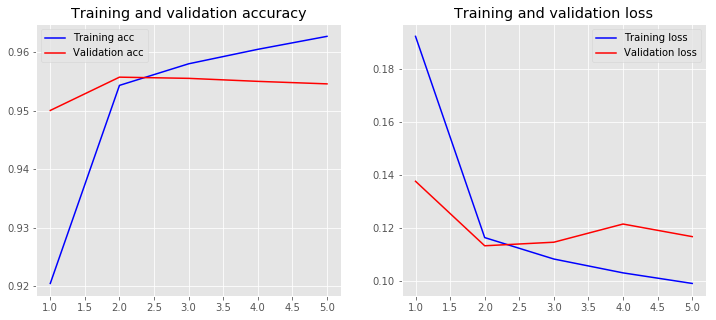

In [18]:
plot_history(history=model_two_history)